In [1]:
!pip install pmdarima


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00


In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima.arima import auto_arima
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/somecode ML'
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')


Mounted at /content/gdrive
/content/gdrive/MyDrive/somecode ML


In [3]:
# dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y %M:%S')
mydata = pd.read_csv('MSN.csv',index_col='Date/Time')

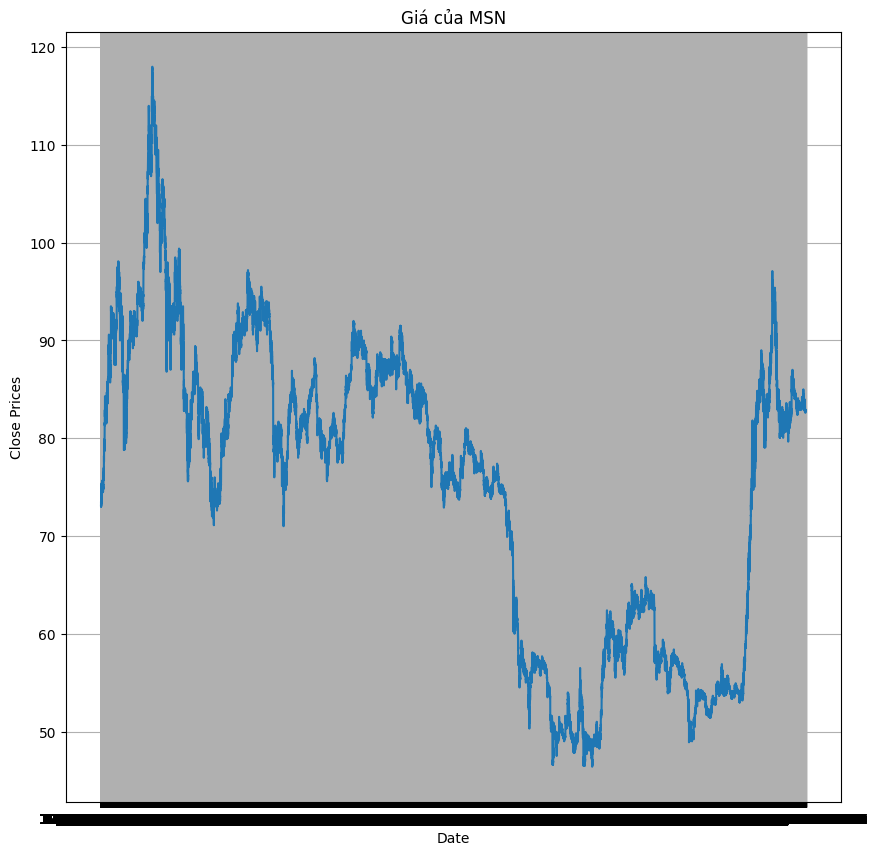

In [4]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(mydata['Close'])
plt.title('Giá của MSN')
plt.show()

In [5]:
def test_stationarity(timeseries):
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(mydata['Close'])

Test Statistics                    -1.460491
p-value                             0.552958
No. of lags used                   65.000000
Number of observations used    135288.000000
critical value (1%)                -3.430398
critical value (5%)                -2.861561
critical value (10%)               -2.566781
dtype: float64


In [6]:
from statsmodels.tsa.statespace.tools import diff
d_mydatad=diff(mydata['Close'])
test_stationarity(d_mydatad)

Test Statistics                   -42.527080
p-value                             0.000000
No. of lags used                   73.000000
Number of observations used    135279.000000
critical value (1%)                -3.430398
critical value (5%)                -2.861561
critical value (10%)               -2.566781
dtype: float64


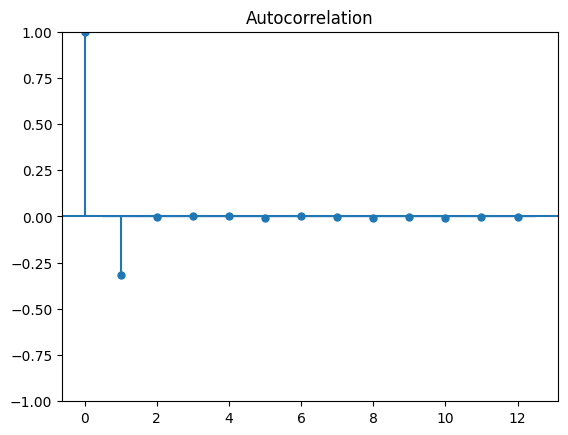

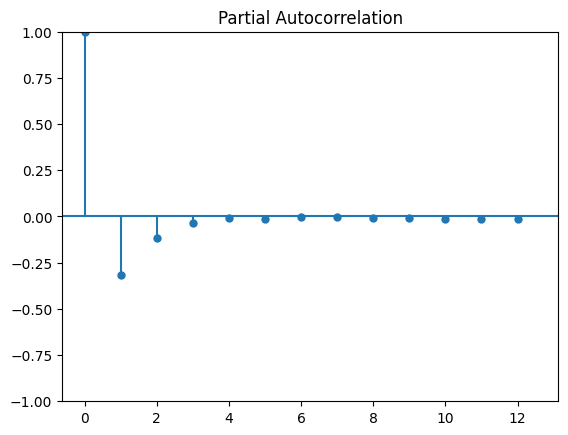

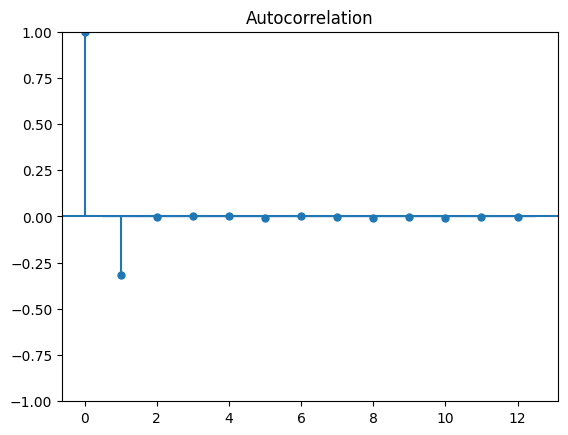

In [7]:
plot_pacf(d_mydatad,lags=12)
plot_acf(d_mydatad,lags=12)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30486.658, Time=26.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-44666.708, Time=23.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-46674.838, Time=29.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30488.643, Time=20.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-46673.241, Time=45.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-46673.248, Time=34.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-46670.912, Time=52.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-46676.797, Time=33.57 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-46675.201, Time=27.60 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-46675.208, Time=23.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-44668.679, Time=19.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-46672.871, Time=31.99 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 369.239 seconds
                               SARIMAX Results    

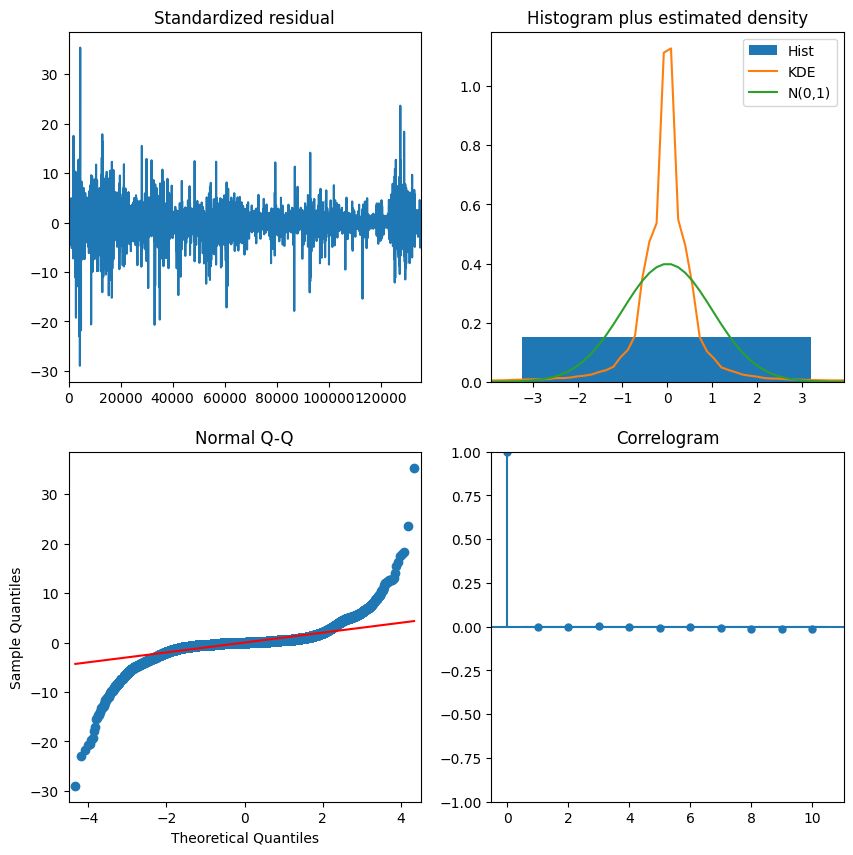

In [8]:
model_autoARIMA = auto_arima(mydata['Close'], start_p=0, start_q=0,
                      max_p=4, max_q=4,  # p tối đa và q tối đa
                      start_P=0,
                      d=1,
                      D=0,seasonal=False,
                      trace=True,
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,10))
plt.show()

       Chi-Sq  Prob>Chi-Sq         F    Prob>F
1    0.074666     0.784660  0.074665  0.784662
2    1.182233     0.553709  0.591109  0.553715
3    1.955581     0.581677  0.651851  0.581685
4    3.662516     0.453601  0.915620  0.453610
5    9.190121     0.101717  1.838067  0.101717
6    9.464567     0.149087  1.577457  0.149088
7    9.844761     0.197543  1.406414  0.197545
8   12.536557     0.128821  1.567111  0.128820
9   18.351630     0.031306  2.039196  0.031303
10  29.636073     0.000982  2.964015  0.000982
11  34.155893     0.000341  3.105590  0.000341
12  38.268546     0.000139  3.189641  0.000139
   Jung-Box   JB-P-val Box-Pierce   BP-P-val
1   lb_stat  lb_pvalue    bp_stat  bp_pvalue
2   lb_stat  lb_pvalue    bp_stat  bp_pvalue
3   lb_stat  lb_pvalue    bp_stat  bp_pvalue
4   lb_stat  lb_pvalue    bp_stat  bp_pvalue
5   lb_stat  lb_pvalue    bp_stat  bp_pvalue
6   lb_stat  lb_pvalue    bp_stat  bp_pvalue
7   lb_stat  lb_pvalue    bp_stat  bp_pvalue
8   lb_stat  lb_pvalue    bp_

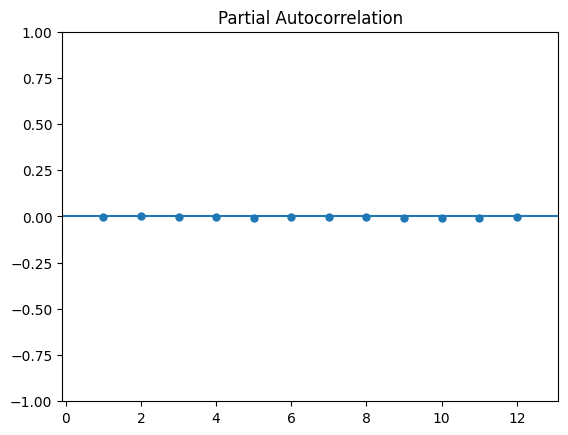

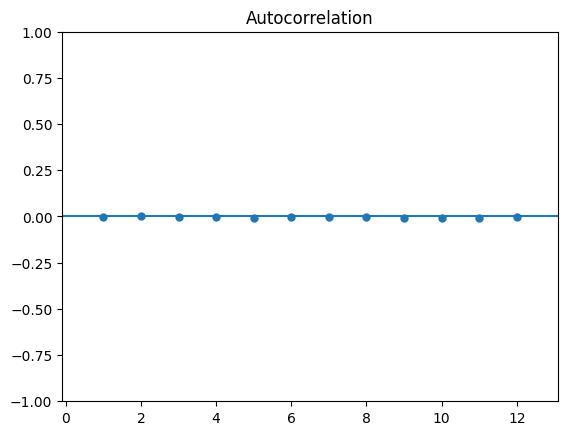

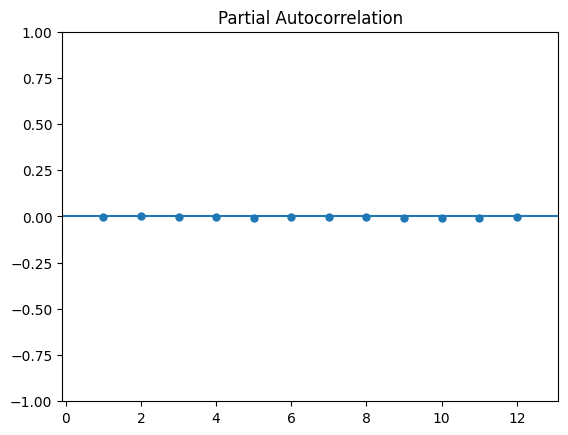

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
model = ARIMA(mydata['Close'], order=(0,1,1))
fitted = model.fit()
fitted.summary()
resids= fitted.resid
lags=12

### Kiểm định tương quan chuỗi BG
chi2=np.zeros(lags)
probChi2=np.zeros(lags)
F=np.zeros(lags)
probf=np.zeros(lags)
for i in range(lags):
    chi2[i],probChi2[i],F[i],probf[i] = sm.stats.diagnostic.acorr_breusch_godfrey(fitted,i+1)
BG_test = pd.DataFrame({'Chi-Sq': chi2, 'Prob>Chi-Sq': probChi2,
                        'F': F, 'Prob>F': probf}, index=range(1,lags+1))
print(BG_test)


### Kiểm định tương quan chuỗi Ljing-Box test

lags =12  # required for the following tests
jb, jbpv, bp, bppv = sm.stats.diagnostic.acorr_ljungbox(resids,lags,True,return_df=False)
JB_test = pd.DataFrame({'Jung-Box': jb,
                    'JB-P-val': jbpv,
                   'Box-Pierce': bp,
                   'BP-P-val': bppv},
                   index=range(1,lags+1))
print(JB_test)


# check for residual autocorrelation ACF and PACF
import statsmodels.graphics.tsaplots as tsaplt
import statsmodels.tsa.api as tsa

acf, acf_confint, lbq, lbqpv = tsa.acf(resids, nlags=lags, alpha=0.05, qstat=True, fft=False)
pacf, pacf_confint = tsa.pacf(resids, nlags=lags, alpha=0.05)
acf_se = (acf_confint[:,1]-acf)/1.96
pacf_se = (pacf_confint[:,1]-pacf)/1.96

ACF_table = pd.DataFrame({'AR': acf[1:], 'AR_se': acf_se[1:],
                          'PAR': pacf[1:], 'PAR_se': pacf_se[1:],
                          'Ljung-Box Q': lbq, 'Q_pval': lbqpv},
                    index=range(1,lags+1))
print(ACF_table)

# plots of ACF and Pacf
tsaplt.plot_acf(fitted.resid, lags=lags, zero=False)
tsaplt.plot_pacf(fitted.resid, lags=lags, zero=False)





In [16]:

predictions = fitted.predict(start=0, end=135353, dynamic=False).rename('ARIMA(0,1,1) Dự báo')
for i in range(len(predictions)):
    print(f"Giá trị dự báo={predictions[i]:<11.10}, Giá trị thực tế={mydata['Close'][i]}")
title = 'Kết quả dự báo trong mẫu'


Streaming output truncated to the last 5000 lines.
Giá trị dự báo=68.2388401 , Giá trị thực tế=68.48
Giá trị dự báo=68.39517524, Giá trị thực tế=68.68
Giá trị dự báo=68.57927109, Giá trị thực tế=69.08
Giá trị dự báo=68.90267817, Giá trị thực tế=69.08
Giá trị dự báo=69.01826632, Giá trị thực tế=68.68
Giá trị dự báo=68.80429388, Giá trị thực tế=69.37
Giá trị dự báo=69.17194566, Giá trị thực tế=68.19
Giá trị dự báo=68.53748676, Giá trị thực tế=68.19
Giá trị dự báo=68.31828064, Giá trị thực tế=68.19
Giá trị dự báo=68.23116701, Giá trị thực tế=68.19
Giá trị dự báo=68.20154003, Giá trị thực tế=69.0
Giá trị dự báo=68.71145332, Giá trị thực tế=68.19
Giá trị dự báo=68.37394214, Giá trị thực tế=67.99
Giá trị dự báo=68.13295983, Giá trị thực tế=68.19
Giá trị dự báo=68.16955144, Giá trị thực tế=69.0
Giá trị dự báo=68.70166777, Giá trị thực tế=69.3
Giá trị dự báo=69.08236107, Giá trị thực tế=69.08
Giá trị dự báo=69.08478154, Giá trị thực tế=69.08
Giá trị dự báo=69.08830778, Giá trị thực tế=70.0
Giá

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



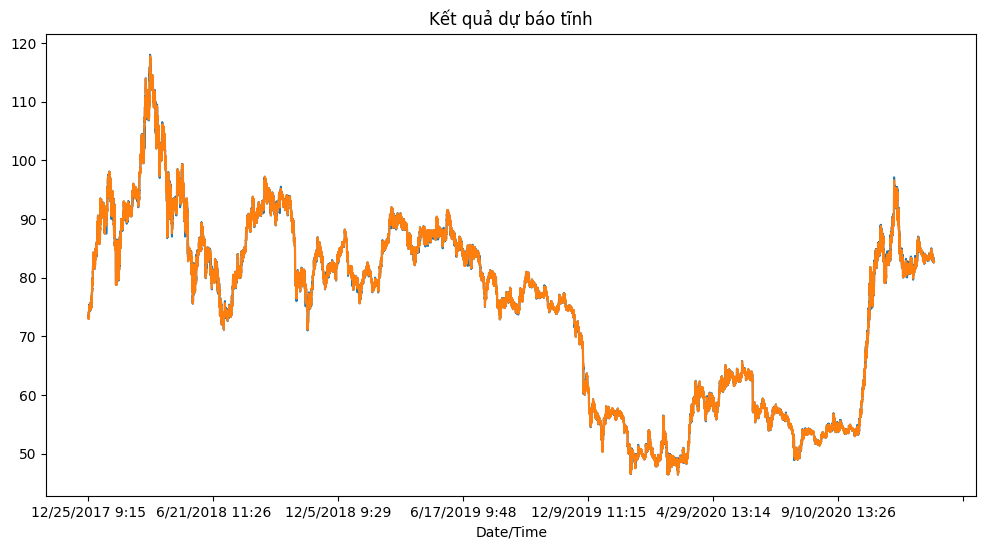

In [17]:
dynamic = fitted.predict(start=1, end=135354, dynamic=False).rename('ARIMA(0,1,1) Forecast')
title = 'Kết quả dự báo tĩnh'
xlabel='Week'
ax = mydata['Close'].plot(legend=False,figsize=(12,6),title=title)
dynamic.plot(legend=False)
ax.autoscale(axis='x',tight=False)


In [18]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], dynamic)
RMSE = rmse(mydata['Close'], dynamic)
MAE = mean_absolute_error(mydata['Close'], dynamic)
MAPE = np.mean(np.abs(dynamic - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,1) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,1) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,1) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,1) MAPE : {MAPE:11.10}')


ARIMA(0,1,1) MSE : 0.005265385573
ARIMA(0,1,1) RMSE : 0.0725629766
ARIMA(0,1,1) MAE : 0.03677544588
ARIMA(0,1,1) MAPE :         nan


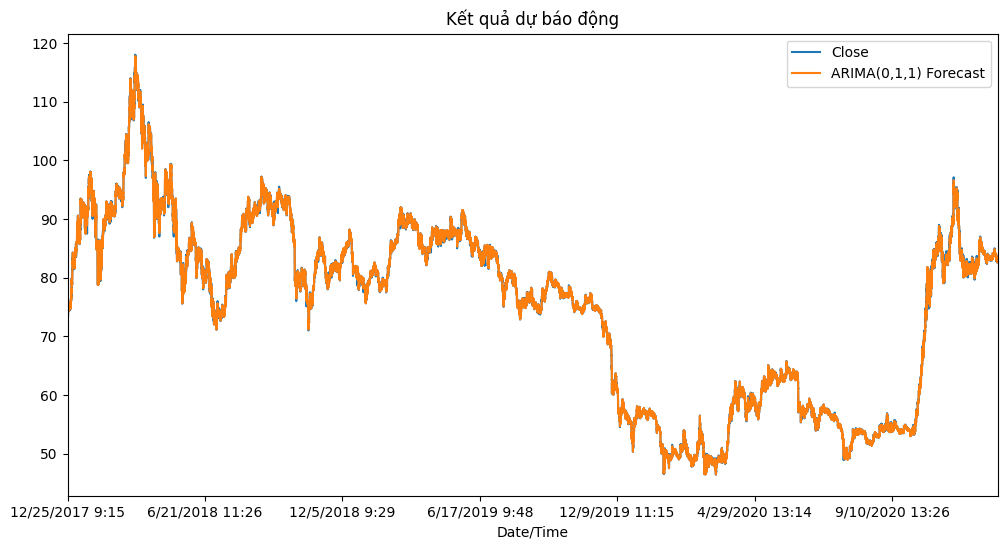

In [19]:
static = fitted.predict(start=1, end=135354, dynamic=False).rename('ARIMA(0,1,1) Forecast')
title = 'Kết quả dự báo động'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
static.plot(legend=True)
ax.autoscale(axis='x',tight=True)


In [20]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], static)
RMSE = rmse(mydata['Close'], static)
MAE = mean_absolute_error(mydata['Close'], static)
MAPE = np.mean(np.abs(static - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,1) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,1) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,1) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,1) MAPE : {MAPE:11.10}')

ARIMA(0,1,1) MSE : 0.005265385573
ARIMA(0,1,1) RMSE : 0.0725629766
ARIMA(0,1,1) MAE : 0.03677544588
ARIMA(0,1,1) MAPE :         nan


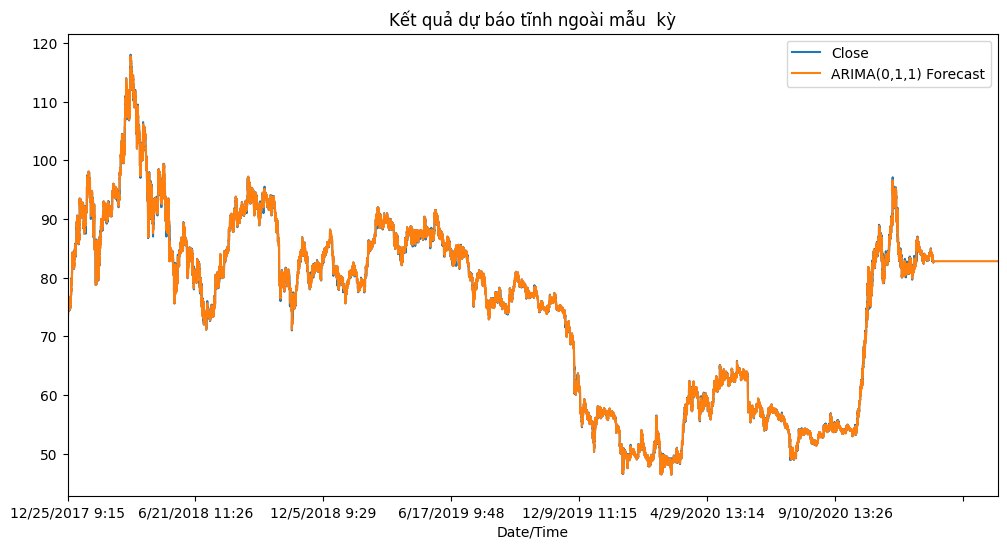

In [14]:
dynamic = fitted.predict(start=1, end=135354+10000, dynamic=False).rename('ARIMA(0,1,1) Forecast')
title = 'Kết quả dự báo tĩnh ngoài mẫu  kỳ'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
dynamic.plot(legend=True)
ax.autoscale(axis='x',tight=True)
